In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from network import Network
from utils import device, get_all_preds, get_num_correct

%matplotlib inline

In [2]:
model = Network().to(device)
model.load_state_dict(torch.load('models/model-run(lr=0.01, batch_size=512).ckpt', map_location=device))

<All keys matched successfully>

In [3]:
model

Network(
  (layer1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2):

In [4]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

train_set = torchvision.datasets.FashionMNIST(
    root='./data/',
    train=True,
    download=True,
    transform=transform
)
test_set = torchvision.datasets.FashionMNIST(
    root='./data/',
    train=False,
    download=True,
    transform=transform
)

In [5]:
model.eval()
with torch.no_grad():
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=6000)
    train_preds = get_all_preds(model, train_loader)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=1000)
    test_preds = get_all_preds(model, test_loader)
    print(train_preds.shape)
    print(test_preds.shape)

torch.Size([60000, 10])
torch.Size([10000, 10])


In [6]:
train_correct = get_num_correct(train_preds, train_set.targets)
test_correct = get_num_correct(test_preds, test_set.targets)

print('Train Correct: {:5}\tTrain Accuracy: {:5.2f}%'.format(train_correct, 100*train_correct/len(train_set)))
print('Test Correct: {:6}\tTest Accuracy: {:6.2f}%'.format(test_correct, 100*test_correct/len(test_set)))

Train Correct: 58922	Train Accuracy: 98.20%
Test Correct:   9185	Test Accuracy:  91.85%


In [7]:
train_stacked = torch.stack(
    (train_set.targets, train_preds.argmax(dim=1)),
    dim=1
)
test_stacked = torch.stack(
    (test_set.targets, test_preds.argmax(dim=1)),
    dim=1
)

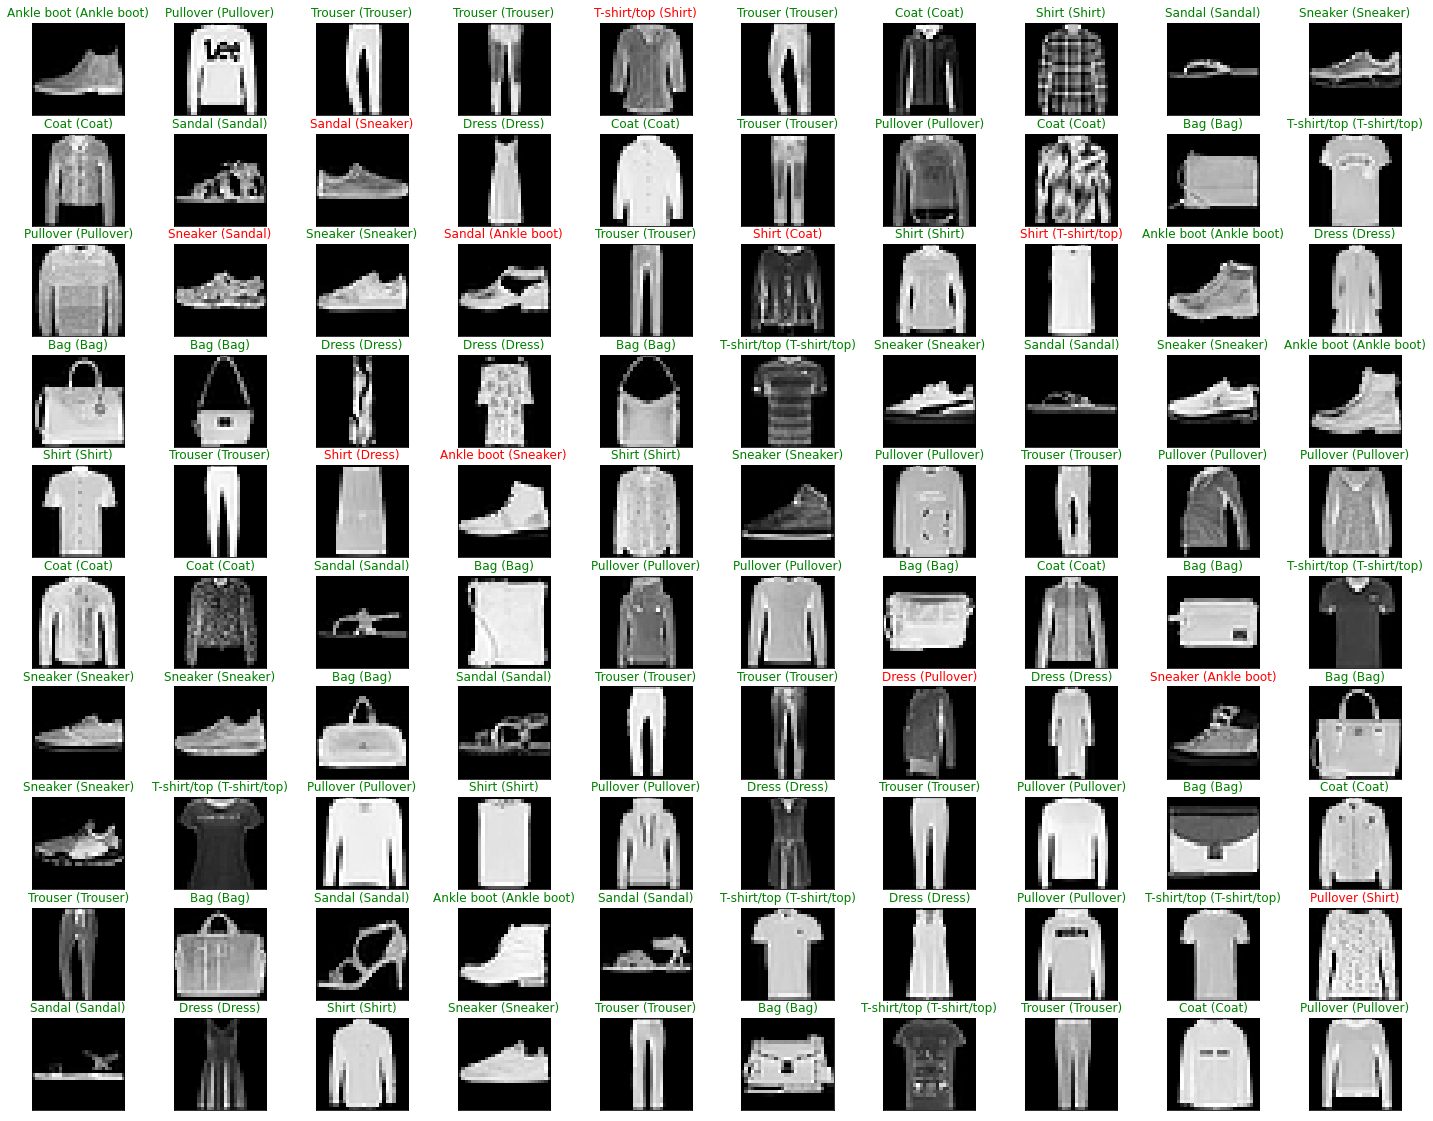

In [8]:
images, labels = next(iter(test_loader))
images = images.numpy()

fig = plt.figure(figsize=(25, 20))
for i in np.arange(100):
    ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[i]), cmap='gray')
    ax.set_title(f"{test_set.classes[test_stacked[i, 1]]} ({test_set.classes[test_stacked[i, 0]]})",
                color=("green" if test_stacked[i, 0]==test_stacked[i, 1] else "red"))

plt.show()
fig.savefig('visualizations/test_results.png', bbox_inches='tight')
plt.close()

In [9]:

train_confmat = torch.zeros(10, 10, dtype=torch.int16)
for row in train_stacked:
    cl, pl = row.tolist()
    train_confmat[cl, pl] += 1

train_confmat

tensor([[5829,    0,   18,    9,    0,    0,  141,    0,    2,    1],
        [   0, 5987,    0,   12,    1,    0,    0,    0,    0,    0],
        [  32,    0, 5859,    4,   70,    0,   34,    0,    0,    1],
        [  12,    1,    9, 5924,   41,    0,   12,    0,    1,    0],
        [   1,    1,   98,   18, 5845,    0,   37,    0,    0,    0],
        [   0,    0,    0,    0,    0, 5982,    0,   13,    0,    5],
        [ 204,    0,  120,   16,   46,    0, 5613,    0,    1,    0],
        [   0,    0,    0,    0,    0,    1,    0, 5921,    0,   78],
        [   0,    0,    1,    0,    0,    1,    0,    0, 5998,    0],
        [   0,    0,    0,    0,    0,    1,    0,   35,    0, 5964]],
       dtype=torch.int16)

In [10]:
test_confmat = torch.zeros(10, 10, dtype=torch.int16)
for row in test_stacked:
    cl, pl = row.tolist()
    test_confmat[cl, pl] += 1

test_confmat

tensor([[862,   2,  11,  13,   4,   3,  98,   1,   6,   0],
        [  4, 979,   0,  13,   1,   0,   2,   0,   1,   0],
        [ 20,   1, 902,   7,  35,   0,  35,   0,   0,   0],
        [ 18,   2,  12, 911,  24,   0,  30,   0,   2,   1],
        [  2,   0,  54,  21, 874,   0,  48,   0,   1,   0],
        [  0,   0,   0,   0,   0, 973,   0,  21,   0,   6],
        [102,   3,  56,  19,  49,   0, 764,   0,   7,   0],
        [  0,   0,   0,   0,   0,   8,   0, 964,   1,  27],
        [  1,   1,   3,   5,   2,   1,   1,   2, 984,   0],
        [  0,   0,   0,   0,   0,   4,   1,  23,   0, 972]], dtype=torch.int16)

In [11]:
for i in range(10):
    print('Train accuracy of {:12s}:\t{:.2f}% ({}/{})'.format(
        train_set.classes[i],
        train_confmat[i, i]/60,
        train_confmat[i, i],
        6000))

Train accuracy of T-shirt/top :	97.15% (5829/6000)
Train accuracy of Trouser     :	99.78% (5987/6000)
Train accuracy of Pullover    :	97.65% (5859/6000)
Train accuracy of Dress       :	98.73% (5924/6000)
Train accuracy of Coat        :	97.42% (5845/6000)
Train accuracy of Sandal      :	99.70% (5982/6000)
Train accuracy of Shirt       :	93.55% (5613/6000)
Train accuracy of Sneaker     :	98.68% (5921/6000)
Train accuracy of Bag         :	99.97% (5998/6000)
Train accuracy of Ankle boot  :	99.40% (5964/6000)


In [12]:
for i in range(10):
    print('Test accuracy of {:12s}:\t{:.2f}% ({}/{})'.format(
        train_set.classes[i],
        test_confmat[i, i]/10,
        test_confmat[i, i],
        1000))

Test accuracy of T-shirt/top :	86.20% (862/1000)
Test accuracy of Trouser     :	97.90% (979/1000)
Test accuracy of Pullover    :	90.20% (902/1000)
Test accuracy of Dress       :	91.10% (911/1000)
Test accuracy of Coat        :	87.40% (874/1000)
Test accuracy of Sandal      :	97.30% (973/1000)
Test accuracy of Shirt       :	76.40% (764/1000)
Test accuracy of Sneaker     :	96.40% (964/1000)
Test accuracy of Bag         :	98.40% (984/1000)
Test accuracy of Ankle boot  :	97.20% (972/1000)


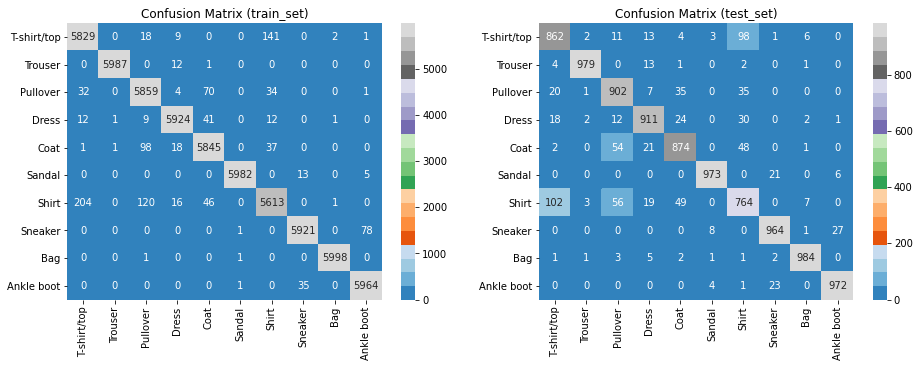

In [13]:
cm_train = pd.DataFrame(train_confmat.numpy(), index = train_set.classes, columns = train_set.classes)
cm_test = pd.DataFrame(test_confmat.numpy(), index = test_set.classes, columns = test_set.classes)

cm_fig = plt.figure(figsize=(100, 60))
ax = cm_fig.add_subplot(10, 12, 1)
ax = sns.heatmap(cm_train, annot=True, cmap="tab20c", fmt="d", annot_kws={"size": 10})
ax.set_title("Confusion Matrix (train_set)")
ax = cm_fig.add_subplot(10, 12, 2)
ax = sns.heatmap(cm_test, annot=True, cmap="tab20c", fmt="d", annot_kws={"size": 10})
ax.set_title("Confusion Matrix (test_set)")

plt.show()
cm_fig.savefig('visualizations/confusion_matrix.png', bbox_inches='tight')
plt.close()
